# ResNet

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
import torchvision
from train_func import *

In [2]:
class ResNetblock(nn.Module):
    def __init__(self,input_channel,out_channel,stride=1, convx=False):
        super(ResNetblock,self).__init__()
        self.C1 = nn.Conv2d(input_channel,out_channel,kernel_size=3,padding=1,stride=stride)
        self.B1 = nn.BatchNorm2d(out_channel)
        self.relu = nn.ReLU()
        self.C2 = nn.Conv2d(out_channel,out_channel,kernel_size=3,padding=1)
        self.B2 = nn.BatchNorm2d(out_channel)

        if convx:
            self.CX = nn.Conv2d(input_channel,out_channel,kernel_size=1,stride=stride)
        else:
            self.CX=None
    
    def forward(self,X):
        Y = self.relu(self.B1(self.C1(X)))
        Y = self.B2(self.C2(Y))
        if self.CX:
            X = self.CX(X)
        Y+=X
        return F.relu(Y)

In [3]:
blk = ResNetblock(3,3)
X=torch.rand((1,3,5,5))
blk(X).shape

torch.Size([1, 3, 5, 5])

In [4]:
blk

ResNetblock(
  (C1): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (B1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (C2): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (B2): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [5]:
blk = ResNetblock(3,5,stride=2,convx=True)
X=torch.rand((1,3,5,5))
blk(X).shape

torch.Size([1, 5, 3, 3])

In [6]:
blk

ResNetblock(
  (C1): Conv2d(3, 5, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (B1): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (C2): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (B2): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (CX): Conv2d(3, 5, kernel_size=(1, 1), stride=(2, 2))
)

In [7]:
class ResNet(nn.Module):
    def __init__(self,input_channel):
        super(ResNet,self).__init__()
        self.model = self.model_(input_channel)
    def forward(self,X):
        return self.model(X)
        
    def head_(self,input_channel):
        head = nn.Sequential(nn.Conv2d(input_channel,64,kernel_size=7,stride=2,padding=3),
                               nn.BatchNorm2d(64),
                               nn.MaxPool2d(kernel_size=3,padding=1,stride=2))
        return head

    def resnetblock_(self,input_channel,output_channel,num_res,first = False):
        block=[]
        for i in range(num_res):
            if i==0 and not first:
                block.append(ResNetblock(input_channel,output_channel,stride=2,convx=True))
            else:
                block.append(ResNetblock(output_channel,output_channel))
        return block

    def model_(self,input_channel):
        b1 = self.head_(input_channel)
        b2 = nn.Sequential(*self.resnetblock_(64, 64, 2, first=True))
        b3 = nn.Sequential(*self.resnetblock_(64, 128, 2))
        b4 = nn.Sequential(*self.resnetblock_(128, 256, 2))
        b5 = nn.Sequential(*self.resnetblock_(256, 512, 2))
        return nn.Sequential(b1, b2, b3, b4, b5,
                        nn.AdaptiveAvgPool2d((1,1)),
                        nn.Flatten(), nn.Linear(512, 10))
    
class ResNetblock(nn.Module):
    def __init__(self,input_channel,out_channel,stride=1, convx=False):
        super(ResNetblock,self).__init__()
        self.C1 = nn.Conv2d(input_channel,out_channel,kernel_size=3,padding=1,stride=stride)
        self.B1 = nn.BatchNorm2d(out_channel)
        self.relu = nn.ReLU()
        self.C2 = nn.Conv2d(out_channel,out_channel,kernel_size=3,padding=1)
        self.B2 = nn.BatchNorm2d(out_channel)

        if convx:
            self.CX = nn.Conv2d(input_channel,out_channel,kernel_size=1,stride=stride)
        else:
            self.CX=None

    def forward(self,X):
        Y = self.relu(self.B1(self.C1(X)))
        Y = self.B2(self.C2(Y))
        if self.CX:
            X = self.CX(X)
        Y+=X
        return F.relu(Y)


In [8]:
model = ResNet(3)

In [9]:
model

ResNet(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): ResNetblock(
        (C1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (B1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
        (C2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (B2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): ResNetblock(
        (C1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (B1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
        (C2): Conv2d(64, 64, kernel_size=(3,

In [10]:
X=torch.rand((1,3,224,224))
model(X)

tensor([[ 0.2389,  0.1066, -0.1480, -0.0761,  0.2860, -0.1706,  0.6081,  0.2363,
          0.7938, -0.2895]], grad_fn=<AddmmBackward0>)

In [11]:
train_dl,test_dl=get_CIFAR10(224,50)

Files already downloaded and verified
Files already downloaded and verified


In [12]:
model = ResNet(3).cuda()
optimizer=torch.optim.AdamW(model.parameters(),lr=0.00005,weight_decay=5e-4) 
train_loop(model,optimizer,train_dl,test_dl,4)

train loss:1.212, test loss: 1.058, test acc: 0.619
train loss:0.766, test loss: 0.924, test acc: 0.689
train loss:0.551, test loss: 0.643, test acc: 0.778
train loss:0.408, test loss: 0.736, test acc: 0.754


In [13]:
optimizer=torch.optim.AdamW(model.parameters(),lr=0.000001,weight_decay=5e-2) 
train_loop(model,optimizer,train_dl,test_dl,5)

train loss:0.219, test loss: 0.449, test acc: 0.848
train loss:0.176, test loss: 0.44, test acc: 0.85
train loss:0.154, test loss: 0.439, test acc: 0.851
train loss:0.138, test loss: 0.439, test acc: 0.853
train loss:0.125, test loss: 0.439, test acc: 0.851


In [18]:
def plot_model(dl,model,row,col,main_title):
    num = row*col
    device = "cuda" if torch.cuda.is_available else "cpu"
    # get valid data set
    valid_x, valid_y = next(iter(dl))[:num]
    fig = plt.figure(figsize=(20, 10))
    pred_label = model(valid_x.to(device)).argmax(dim=1)
    true_label = valid_y
    for i in range(1, row * col + 1):
        plt.subplot(col, row, i)
        plt.axis('off')
        plt.imshow(valid_x[i - 1].detach().numpy().transpose((1, 2, 0)), cmap='gray_r')
        title = f'true:{true_label[i - 1]},pred:{pred_label[i - 1]}'
        plt.title(title, fontsize=10)
    fig.suptitle(main_title, fontsize=20)
    plt.savefig(main_title, facecolor="w")
    plt.show()

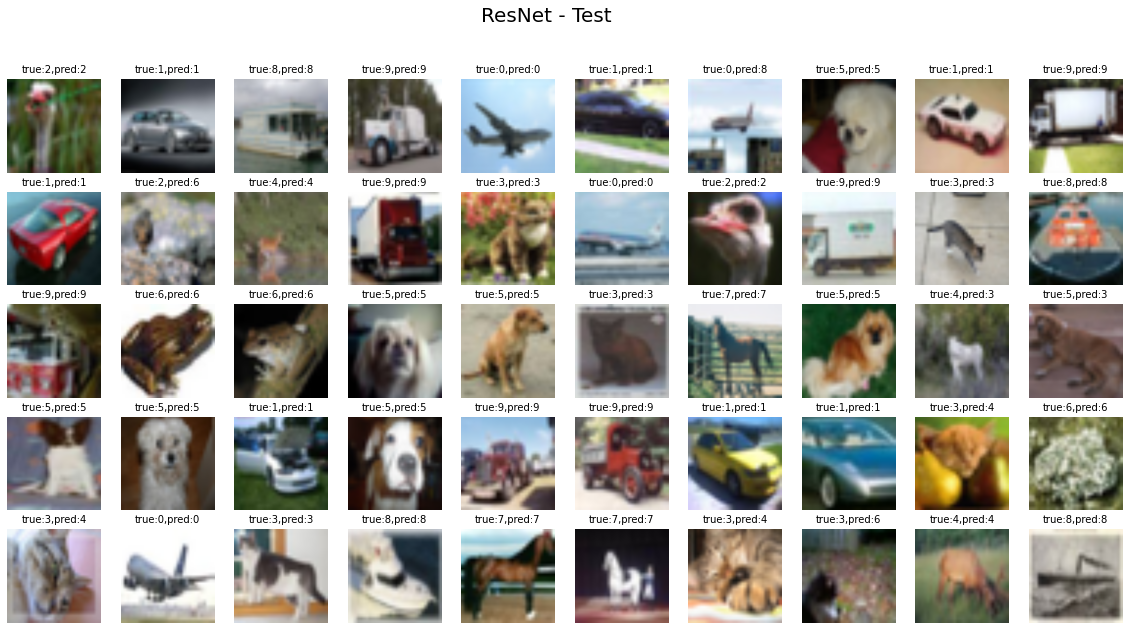

In [19]:
import matplotlib.pyplot as plt
plot_model(test_dl,model,10,5,"ResNet - Test")

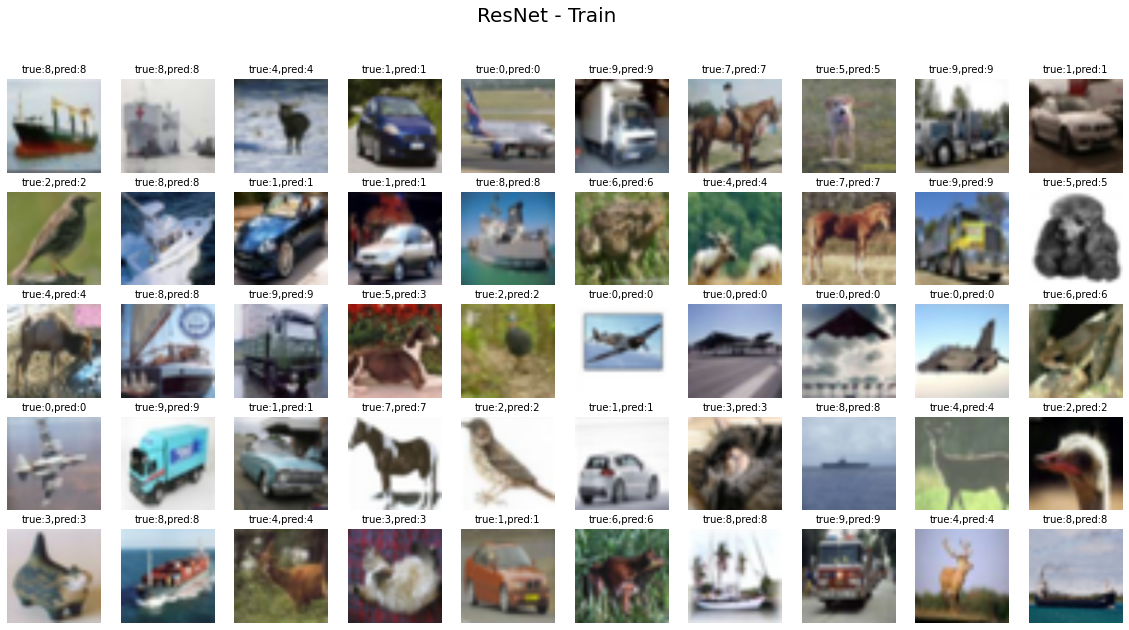

In [20]:
plot_model(train_dl,model,10,5,"ResNet - Train")